# <center>Machine Learning Lab: Exercise Sheet 9</center>
<center> <b>Submitted By: Mohit Bansal</b></center>
<center> <b>Student ID: 279314</b></center>

#### 1. Sparse dataset :
+ w8a dataset D1: https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary.html#
    
#### 2. UCI Dataset:
+ SMS Spam D2: https://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection
+ Spambase D3: https://archive.ics.uci.edu/ml/datasets/Spambase


# Exercise 1: A spam filter using SVM (16 Points)

## Part A: (8 Points): Build a spam filter using a pre-processed dataset

+ A spam filter classify an email to be Ham or Spam, using the content of an email as features
+ You have to use dataset D3 for this task. Build a basic spam filter using SVM. 
+ You have to use libsvm https://github.com/cjlin1/libsvm/tree/master/python. 
+ libsvm accepts data in a libsvm format. Each data row in a libsvm format is given as:
        < label > < index1 >:< value1 > < index2 >:< value2 >. . .
+ Convert dataset D3 into a libsvm format. 
+ Follow the readme document given on the libsvm link to see how you can use it to solve your problem. 
+ You have to learn a spam classifier on train part of the dataset and evaluate it on test dataset. 
+ Also optimize the hyper parameter i.e. value of C. [hint: when choosing the range of hyperparameter its always useful to check a diverse range i.e. C ={1,2,3,4} is not a good range to check for optimal value, you might want to check a broader range going from 0.1 to 100 etc.]. 
+ Present your results in form of graphs and tables, listing details. 
+ You have to choose a quality criterion according to the given problem i.e. classification. 

Note: If you are not able to use libsvm you can replace it with scikit learn. But you have to convert your data into libsvm format.

## Solution:

### Step 0: Loading Libraries

In [9]:
# Import Libraries
import os
import csv
import operator
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import RandomState
from sklearn.cross_validation import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.grid_search import GridSearchCV
from sklearn import feature_extraction, model_selection, naive_bayes, metrics, svm

### Step 1: Loading Dataset

We will first load the data

In [10]:
# Read the training data
path = '/Users/mundanemohit/Google Drive/My Work/MSc. Data Analytics/WiSe 18/3113 Machine Learning Lab/Excercises/Ex9'
os.chdir(path)
filename = 'spambase.data'
spamDF = pd.read_csv(filename, header=None)
spamDF = np.array(spamDF)

print("Spam Dataset has %d rows and %d columns." % (spamDF.shape[0], spamDF.shape[1]+1))
print(spamDF)

Spam Dataset has 4601 rows and 59 columns.
[[0.000e+00 6.400e-01 6.400e-01 ... 6.100e+01 2.780e+02 1.000e+00]
 [2.100e-01 2.800e-01 5.000e-01 ... 1.010e+02 1.028e+03 1.000e+00]
 [6.000e-02 0.000e+00 7.100e-01 ... 4.850e+02 2.259e+03 1.000e+00]
 ...
 [3.000e-01 0.000e+00 3.000e-01 ... 6.000e+00 1.180e+02 0.000e+00]
 [9.600e-01 0.000e+00 0.000e+00 ... 5.000e+00 7.800e+01 0.000e+00]
 [0.000e+00 0.000e+00 6.500e-01 ... 5.000e+00 4.000e+01 0.000e+00]]


### Step 2: Convert dataset into Sparse Matrix (LibSVM)

So we have 58 attributes for 4601 rows of data. We need to convert this data into a sparse matrix for building our spam classifier. For this purpose we will use the dump_svmlight_file inbuilt library from sklearn.

In [3]:
from sklearn.datasets import dump_svmlight_file, load_svmlight_file

# First, we will seperate the X & y components
X = spamDF[:,:-1]                 # Extract attributes    
y = spamDF[:,-1]                  # Extract dependent variable

# Export the data into libsvm format
dump_svmlight_file(X, y, 'spam.dat',zero_based=True,multilabel=False)

# Reload the sparse data
df = load_svmlight_file("spam.dat")

print(df)

(<4601x57 sparse matrix of type '<class 'numpy.float64'>'
	with 59231 stored elements in Compressed Sparse Row format>, array([1., 1., 1., ..., 0., 0., 0.]))


### Step 3: Learning Classifier


In [4]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(df[0], df[1], test_size=0.30, random_state = 42)

# Regularization parameter
params = [{'C': [0.1 ], #1, 10], #, 50, 100
           'kernel': ['linear']}]
model = svm.SVC()               
grid = GridSearchCV(model, params, cv = 5)

In [5]:
grid.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'C': [0.1], 'kernel': ['linear']}],
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [6]:
pd.DataFrame(grid.grid_scores_)

,parameters,mean_validation_score,cv_validation_scores
0,"{'C': 0.1, 'kernel': 'linear'}",0.921118,"[0.9085271317829458, 0.9161490683229814, 0.917..."


In [7]:
print("Best estimator found by grid search:")
print(grid.best_estimator_)

Best estimator found by grid search:
SVC(C=0.1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


In [8]:
svc = grid.best_estimator_
svc.fit(X_train, y_train)
score_train = svc.score(X_train, y_train)
score_test = svc.score(X_test, y_test)
print("Training Accuracy ---> ", np.round(score_train,5))
print("Test Accuracy --->", np.round(score_test, 5))

Training Accuracy --->  0.92733
Test Accuracy ---> 0.92397


 **Due to processing time constraints, I was unable to test the model for more than 1 regularization values**

## Part B: (8 Points): Pre-processed a dataset and learn SVM

+ The dataset D2 is not preprocessed. It consists of label[ham or spam] and content of sms text. 
+ Your task in this part is to pre-process this data into a processable format. 
+ Using OneHotEnconding might not help, therefore you have to use other means of converting text data into features. 
+ You can look at scikit-learn text feature extraction utilities i.e. TFIDF or count. 
+ You might also want to get rid of the stop words i.e. This, the, is, a etc, which appear in almost all the documents. 
+ After preprocessing you have to use SVM implementation provided by scikit-learn. 
+ Here you will experiment with different hyperparameters and two kernels (linear and RBF). 
+ As usual you will perform 5-fold cross validation and present the score using plots and tables. 
+ You might also want to look at sklearn.pipeline.Pipeline utility to streamline your workflow.

## Solution:

### Step 1: Loading Dataset

In [85]:
data = pd.read_csv('SMSSpam', sep='\t', header=None, names=('y','x'))
print(data.shape)
data.head()

(5572, 2)


,y,x
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


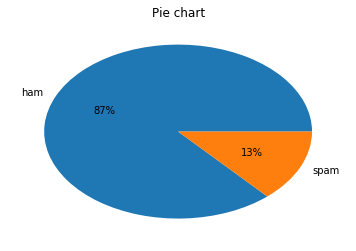

In [86]:
# Let's see distribution of classes in the dataset
count_Class=pd.value_counts(data["y"], sort= True)
count_Class.plot(kind = 'pie',  autopct='%1.0f%%')
plt.title('Pie chart')
plt.ylabel('')
plt.show()

## Step 2: Feature Engineering

Now we will seperate the words in a message into features. For this, we will use the counter class.

In [87]:
from collections import Counter

count1 = Counter(" ".join(data[data['y']=='ham']["x"]).split()).most_common(20)
df1 = pd.DataFrame.from_dict(count1)
df1 = df1.rename(columns={0: "words in non-spam", 1 : "count"})
count2 = Counter(" ".join(data[data['y']=='spam']["x"]).split()).most_common(20)
df2 = pd.DataFrame.from_dict(count2)
df2 = df2.rename(columns={0: "words in spam", 1 : "count_"})
df2.head()

,words in spam,count_
0,to,607
1,a,360
2,your,187
3,call,185
4,or,185


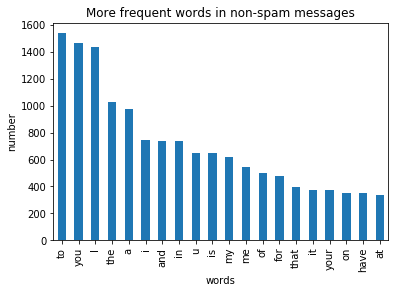

In [88]:
df1.plot.bar(legend = False)
y_pos = np.arange(len(df1["words in non-spam"]))
plt.xticks(y_pos, df1["words in non-spam"])
plt.title('More frequent words in non-spam messages')
plt.xlabel('words')
plt.ylabel('number')
plt.show()

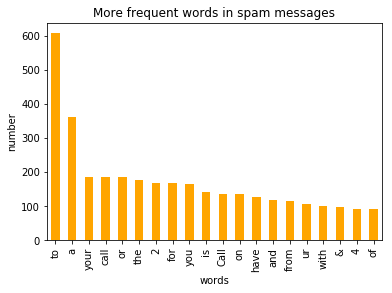

In [89]:
df2.plot.bar(legend = False, color = 'orange')
y_pos = np.arange(len(df2["words in spam"]))
plt.xticks(y_pos, df2["words in spam"])
plt.title('More frequent words in spam messages')
plt.xlabel('words')
plt.ylabel('number')
plt.show()

We can see that the majority of frequent words in both classes are stop words such as 'to', 'a', 'or' and so on. With stop words we refer to the most common words in a lenguage, there is no simgle, universal list of stop words. We remove the stop words in order to improve the analytics.

In [90]:
print("Before feature extraction: ", np.shape(data))
f = feature_extraction.text.CountVectorizer(stop_words = 'english')
X = f.fit_transform(data["x"])

print("After feature extraction : ", np.shape(X))
X

Before feature extraction:  (5572, 2)
After feature extraction :  (5572, 8444)


<5572x8444 sparse matrix of type '<class 'numpy.int64'>'
	with 43578 stored elements in Compressed Sparse Row format>

Thus, now we have 8,444 new features for each text, i.e. a sparse matrix. Each feature is a unique word and it's value is 1 or 0 based on whether or not it occurs in the text.

We will convert the ham/spam column into binary feature

In [91]:
data["y"]= data["y"].map({'spam':1,'ham':0})
data.head()

,y,x
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


## Step 3: Support Vector Machines

We will now test the SVM implementation on this transformed dataset using following steps:
+ Perform Grid-Search for hyper-paramater 'C' (Regularization) and the kernel (linear/rbf)
+ Find out best estimator based on training set performance
+ Evaluate performance on the test set

In [17]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, data['y'], test_size=0.30, random_state=42)

# Regularization parameter
params = [{'C': np.arange(500, 1000, 100),
           'kernel': ['rbf', 'linear']}]
model = svm.SVC()               
grid = GridSearchCV(model, params, cv = 5)
grid.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'C': array([500, 600, 700, 800, 900]), 'kernel': ['rbf', 'linear']}],
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [18]:
pd.DataFrame(grid.grid_scores_)

,parameters,mean_validation_score,cv_validation_scores
0,"{'C': 500, 'kernel': 'rbf'}",0.977179,"[0.9782330345710627, 0.9846350832266325, 0.965..."
1,"{'C': 500, 'kernel': 'linear'}",0.978974,"[0.9769526248399488, 0.9846350832266325, 0.967..."
2,"{'C': 600, 'kernel': 'rbf'}",0.977949,"[0.9782330345710627, 0.9846350832266325, 0.965..."
3,"{'C': 600, 'kernel': 'linear'}",0.978974,"[0.9769526248399488, 0.9846350832266325, 0.967..."
4,"{'C': 700, 'kernel': 'rbf'}",0.979487,"[0.9782330345710627, 0.9859154929577465, 0.967..."
5,"{'C': 700, 'kernel': 'linear'}",0.978974,"[0.9769526248399488, 0.9846350832266325, 0.967..."
6,"{'C': 800, 'kernel': 'rbf'}",0.979744,"[0.9782330345710627, 0.9859154929577465, 0.967..."
7,"{'C': 800, 'kernel': 'linear'}",0.978974,"[0.9769526248399488, 0.9846350832266325, 0.967..."
8,"{'C': 900, 'kernel': 'rbf'}",0.979744,"[0.9782330345710627, 0.9846350832266325, 0.967..."
9,"{'C': 900, 'kernel': 'linear'}",0.978974,"[0.9769526248399488, 0.9846350832266325, 0.967..."


We can already see an accuracy of close to 98% with cross-validation. We will use the best estimator to see the performance on the test set.

In [19]:
print("Best estimator found by grid search:")
print(grid.best_estimator_)

Best estimator found by grid search:
SVC(C=800, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


In [20]:
svc = grid.best_estimator_
svc.fit(X_train, y_train)
score_train = svc.score(X_train, y_train)
score_test = svc.score(X_test, y_test)
print("Training Accuracy ---> ", np.round(score_train,5))
print("Test Accuracy --->", np.round(score_test, 5))

Training Accuracy --->  0.99769
Test Accuracy ---> 0.98744


# Exercise 2: Compare SVM based spam filter with another model (4 Points)

+ You have to compare results obtained in one of the task above with another model of your choice (decision trees or logistic regression etc). 
+ Optimize the hyperparameters and perform 5-fold cross validation. 
+ You can use scikit-learn implementation. 
+ Compare the results and accuracy. 
+ Finally conclude your findings.

# Solution

We will use a Decision-Tree classifier for comparison purposes. To build & test the classifier, we will need the following functions:

+ <b>load_data()</b>: Function to load data and divide it into training and testing sets if necessary
+ <b>Find_HyperParams()</b>: Function to iteratively determine the best hyperparameter combination for the decision tree based on the training set. We will use 5-fold cross-validation with Grid-search.
+ <b>Top_K_Features()</b>: Function to find top k features based on their weightage in the model.
+ <b>Show_AUC()</b>: Function to print the area under the curve. This is one of the determinants of model performance.

In [ ]:
# If Train is True, we split the dataset into training and testing
# size variable specifies the train-test ratio
def load_data(Train=False, size = 0.3):
    # Read the training data
    path = '/Users/mundanemohit/Google Drive/My Work/MSc. Data Analytics/WiSe 18/3113 Machine Learning Lab/Excercises/Ex9'
    os.chdir(path)
    filename = 'spambase.data'
    data = pd.read_csv(filename, header=None)
    data = np.array(data)

    X = np.array([x[:-1] for x in data]).astype(np.float)    # Extract attributes    
    y = np.array([x[-1] for x in data]).astype(np.float)     # Extract dependent variable
    
    del data # free up the memory
    
    if Train:
        # returns X_train, X_test, y_train, y_test
        return train_test_split(X, y, test_size=size, random_state=RandomState())
    else:
        return X, y

def find_hyperparams(clf, X, y):
    # Set the parameters by cross-validation
    param_grid = [{'criterion': ['gini', 'entropy'],
                    'splitter': ['best', 'random'],
                    'max_features': ['sqrt', 'log2', None, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9 ]}]
    grid = GridSearchCV(clf, param_grid, cv = 5)
    grid.fit(X, y)
    print('Grid-Search performed with 5-Folds!')
    return grid.best_estimator_

def top_k_features(k, weights):
# User data
    word_labels = ['wf_make', 'wf_address', 'wf_all', 'wf_3d', 'wf_our', 'wf_over', 'wf_remove', 'wf_internet', 'wf_order',
                'wf_mail', 'wf_receive', 'wf_will', 'wf_people', 'wf_report', 'wf_addresses', 'wf_free', 'wf_business',
                'wf_email', 'wf_you', 'wf_credit', 'wf_your', 'wf_font', 'wf_000','wf_money', 'wf_hp',  'wf_hpl', 
                'wf_george', 'wf_650', 'wf_lab', 'wf_labs', 'wf_telnet', 'wf_857', 'wf_data', 'wf_415', 'wf_85',
                'wf_technology', 'wf_1999', 'wf_parts', 'wf_pm', 'wf_direct', 'wf_cs', 'wf_meeting', 'wf_original',
                'wf_project', 'wf_re', 'wf_edu', 'wf_table', 'wf_conference' , 'cf_;', 'cf_(', 'cf_[', 'cf_!', 'cf_$', 
                'cf_#', 'capital_run_length_average', 'capital_run_length_longest', 'capital_run_length_total' ]
    
    return sorted(zip(word_labels, weights), reverse=True, key=operator.itemgetter(1))[:k]

def show_auc(y_true, y_score):
    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

Let's perform the analysis now with 10 iterations to see the avg. score of the model

Grid-Search performed with 5-Folds!

Best hyperparameters:  DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=0.1, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='random')


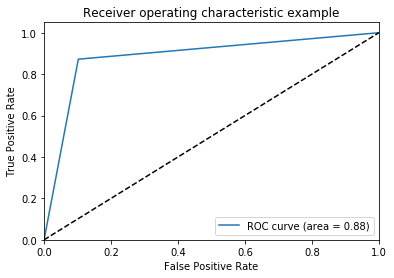

Top 5 Features: 
[('wf_000', 0.08715979440535351), ('wf_our', 0.07992912033078307), ('wf_business', 0.079502269043142), ('wf_credit', 0.06516712844507547), ('cf_!', 0.058065400552069775)]


Accuracy ---> Avg: 0.89710, Std: 0.01366

AUC     ---> Avg: 0.89316, Std: 0.01424


In [22]:
iterations = 10
scores = []
roc_auc = []

# Find the best combination of hyperparameters
clf = DecisionTreeClassifier()
best_Tree = find_hyperparams(clf, X_train, y_train)
print("\nBest hyperparameters: ", best_Tree)
    
# Use these parameters to test the model
for i in range(iterations):
    X_train, X_test, y_train, y_test = load_data(Train=True)
    clf = best_Tree
    clf.fit(X_train, y_train)
    scores.append(clf.score(X_test, y_test))
    fpr, tpr, _ = roc_curve(y_test, clf.predict_proba(X_test)[:, 1])
    roc_auc.append(auc(fpr, tpr))

# Print AUC Graph
show_auc(y_test, clf.predict_proba(X_test)[:, 1])
print("Top 5 Features: ")
print(top_k_features(5, clf.feature_importances_))
    
print('\n\nAccuracy ---> Avg: %0.5f, Std: %0.5f' % (np.mean(scores), np.std(scores)))
print('\nAUC     ---> Avg: %0.5f, Std: %0.5f' % (np.mean(roc_auc), np.std(roc_auc)))

## Conclusion

A **decision tree** based model achieved an accuracy of 89.7% which was significantly lower than the 92.7% accuracy with **SVM**. This is because an SVM has more dimensions than a tree-based model and can thus create finer classification layers. However, SVM model also requires more computational power and is thus better suited for smaller, sparse classification problems.

References:
    
+ https://github.com/sampepose/SpamClassifier/blob/
+ https://www.kaggle.com/pablovargas/naive-bayes-svm-spam-filtering